In [2]:
from plotnine import *
import pandas as pd
import numpy as np
from pulp import *
import ipywidgets as widgets
from data.mock_data_generator import generate_mock_data
import matplotlib.pyplot as plt
from model.model_creator import create_model

# Data

Data contains transaction log of the past 1 year, and records are classified by the type of expenditure:
1. grocery
2. fashion
3. household
4. online shopping
5. travels

Let's assume that there is associated importance with each transaction record. This can be of direct dependency of type field, manually labeled or learned (separate task)

| info     |  type  | amount | importance | week |
|----------|--------|--------|------------|------|
| Lidl     |   1    |  60.0  |     1      |  3   |
| Zalando  |   2    |  45.0  |     2      |  28  |
| Rent Aug |   3    | 1450.0 |     10     |  17  | 



In [5]:
data = generate_mock_data(350)

In [6]:
def visualize_data(data):
    types =['grocery','fashion','household','online shopping','travels']
    summed = data.groupby(['type']).sum().reset_index()
    plt.pie(summed['amount'],labels=np.take(types,summed['type']-1),autopct='%1.1f%%')
    plt.title('My Expenses')
    plt.axis('equal')
    plt.show()
    print(f"Total expenses for the year are {data.sum()['amount']} Euros")
    

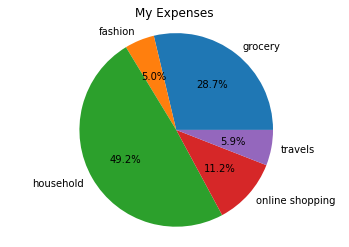

Total expenses for the year are 29281.35 Euros


In [7]:
visualize_data(data)

# Problem
You would like to understand which type of expenses you need to cut in future in order to achieve a certain savings per year.
Given a savings amount X, you need to return a list of transactions with minimal total importance, which you could have cut during current year, in order to save this amount.

Sanity rules:
* You know that there is a certain amount you need to spend on groceries (you need to eat)
* Every season you need to spend a certain amount on clothing 
* In general, you cannot avoid paying for household 


# Model
### Decision
Take or not to take the corresponding transaction. Let transaction be indexed by $n \in \mathcal{N}$. Then the decision variable, corresponding to taking or not taking transaction $n$ is $z_n \in \{0,1\}$

### Optimization goal, i.e. objective function
We want to minimize the total importance of all the transaction we decide to remove, in order to achieve certain savings goal. If $I_n$ is importance of transaction $n$, then our goal is to
\begin{align*}
\min \sum_{n \in N} I_n z_n
\end{align*}


In [8]:
savings = 0.1
grocery_per_week = 50.0

In [9]:
model, decision_vars = create_model(data, savings, grocery_per_week)

/home/vfux/Repositories/budget_optimization/.venv/lib/python3.6/site-packages/pulp/pulp.py:1195: UserWarning: Spaces are not permitted in the name. Converted to '_'


In [81]:
model = pulp.LpProblem("Profit maximising problem", -1)
decision_vars = LpVariable.dicts("Transaction",range(len(data)),0,1,LpInteger)


/home/vfux/Repositories/budget_optimization/.venv/lib/python3.6/site-packages/pulp/pulp.py:1195: UserWarning: Spaces are not permitted in the name. Converted to '_'


In [11]:
model.solve()
print(f"Model has status {pulp.const.LpStatus[model.status]}")

Model has status Optimal


In [12]:
print(pulp.value(model.objective))


1678.0


In [13]:
sum([decision_vars[t].varValue* data.loc[t,'amount'] for t in range(len(data))])

26309.479999999996

In [14]:
mask = np.array([True if decision_vars[t].varValue > 0.5 else False for t in range(len(data))])

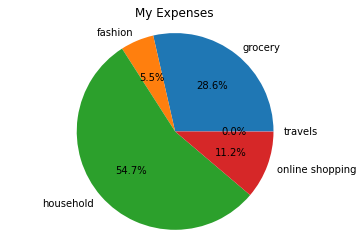

Total expenses for the year are 26309.48 Euros


In [15]:
visualize_data(data[mask])

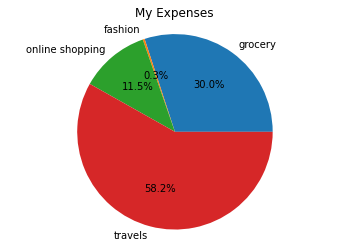

Total expenses for the year are 2971.87 Euros


In [92]:
visualize_data(data[~mask])

In [93]:
data[~mask]

,info,type,amount,week,importance
2,Booking.com,5,888.09,23,8
4,Edeka,1,32.24,6,0
11,Lidl,1,4.85,8,0
14,Rewe,1,3.30,33,0
34,Rewe,1,23.91,34,0
37,Amazon,4,48.78,17,0
40,Rewe,1,28.68,39,0
41,Lidl,1,38.60,25,0
42,Lidl,1,0.77,1,0
51,Amazon,4,49.83,36,0
